# **Utilização de RNN em séries temporais**

Dados:

Vendas Mensais Antecipadas para Varejo e Serviços de Alimentação
Unidades: Milhões de Dólares, não Ajustados Sazonalmente.
Frequência: Mensal

Pretende-se utilizar RNN para prever valores de vendas mensais em 12 meses no futuro.

A série associada da Pesquisa Mensal de Comércio Varejista está disponível em https://fred.stlouisfed.org/series/MRTSSM448USN

Informações sobre a Pesquisa Mensal Antecipada de Vendas no Varejo podem ser encontradas no site do Censo em https://www.census.gov/retail/marts/about_the_surveys.html

In [82]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
df = pd.read_csv('/content/drive/MyDrive/colab_notebooks/projetos/forecast_RNN/sales_price.csv',index_col='DATE',parse_dates=True)

In [61]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [62]:
df.columns = ['Sales']

<Axes: xlabel='DATE'>

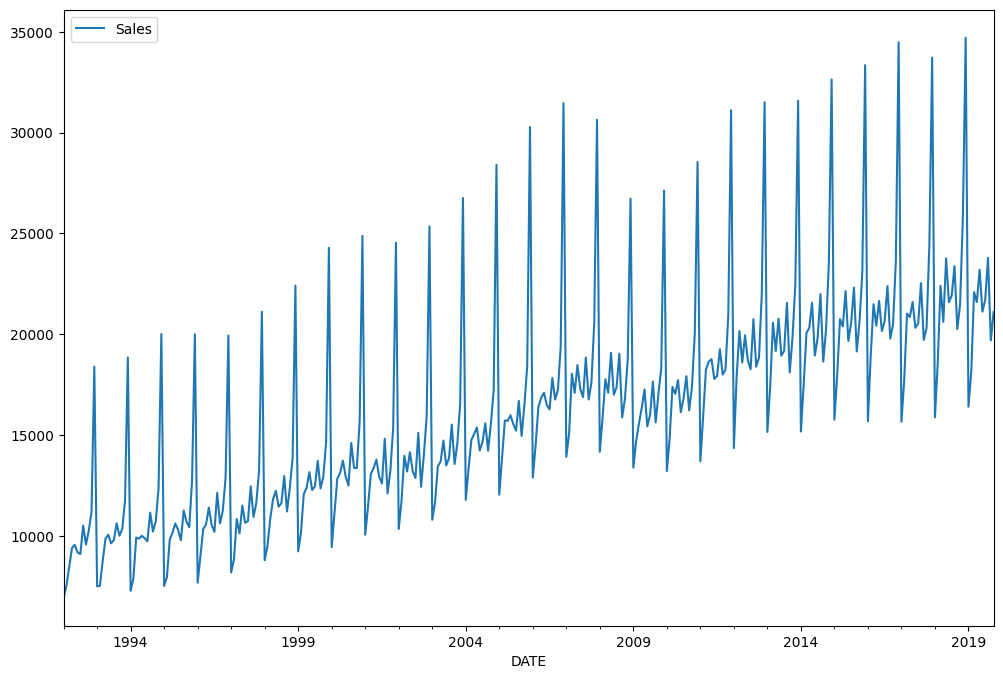

In [63]:
df.plot(figsize=(12,8))

In [64]:
len(df)

334

Os dados estão em meses. Será feito um forecast de 1,5 ano.

In [65]:
len(df) - 18

316

In [66]:
test_size = 18

In [67]:
test_ind = len(df) - test_size

In [68]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [69]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [70]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


Deixando os dados na mesma escala:

In [71]:
scaler = MinMaxScaler()

In [72]:
scaler.fit(train)

MinMaxScaler()

In [73]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

Pegando os dados de 12 meses anteriores para prever 1 mês no futuro

In [75]:
length = 12
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [76]:
X,y = generator[0]

In [77]:

print(f'Dado a lista: \n{X.flatten()}')
print(f'Preveja y: \n {y}')

Dado a lista: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Preveja y: 
 [[0.02047633]]


Criando o modelo:

In [79]:
n_features = 1

In [80]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [81]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

EarlyStopping e criando um validador

In [83]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [84]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [100]:
model.fit(generator, epochs=10,
          validation_data=validation_generator,
          callbacks=[early_stop])

Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 2/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0011 - val_loss: 3.1360e-04
Epoch 3/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.3318e-04 - val_loss: 0.0018
Epoch 4/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.8869e-04 - val_loss: 0.0013


<Axes: >

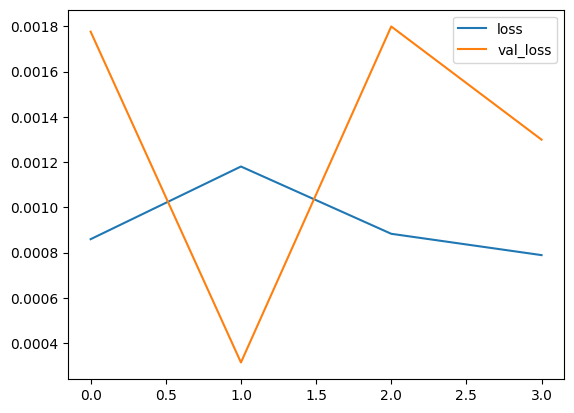

In [101]:
losses = pd.DataFrame(model.history.history)
losses.plot()

Avaliando nos dados de teste

In [102]:
first_eval_batch = scaled_train[-length:]

In [103]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [104]:
model.predict(first_eval_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


array([[0.5533763]], dtype=float32)

In [105]:
scaled_test[0]

array([0.61087714])

In [114]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):

    # obter previsão 1 tempo à frente ([0] é para pegar apenas o número em vez da [matriz])
    current_pred = model.predict(current_batch)[0]

    # Armazena as predições
    test_predictions.append(current_pred)

    #atualizar lote para incluir a ultima previsão
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [109]:
true_predictions = scaler.inverse_transform(test_predictions)

In [111]:
test['Predictions'] = true_predictions

/tmp/ipython-input-4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [112]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22180.197276
2018-06-01,21589,21026.028731
2018-07-01,21919,21254.818132
2018-08-01,23381,23118.674304
2018-09-01,20260,20463.545365
2018-10-01,21473,21057.323776
2018-11-01,25831,25360.735575
2018-12-01,34706,34833.058758
2019-01-01,16410,16356.028857


<Axes: xlabel='DATE'>

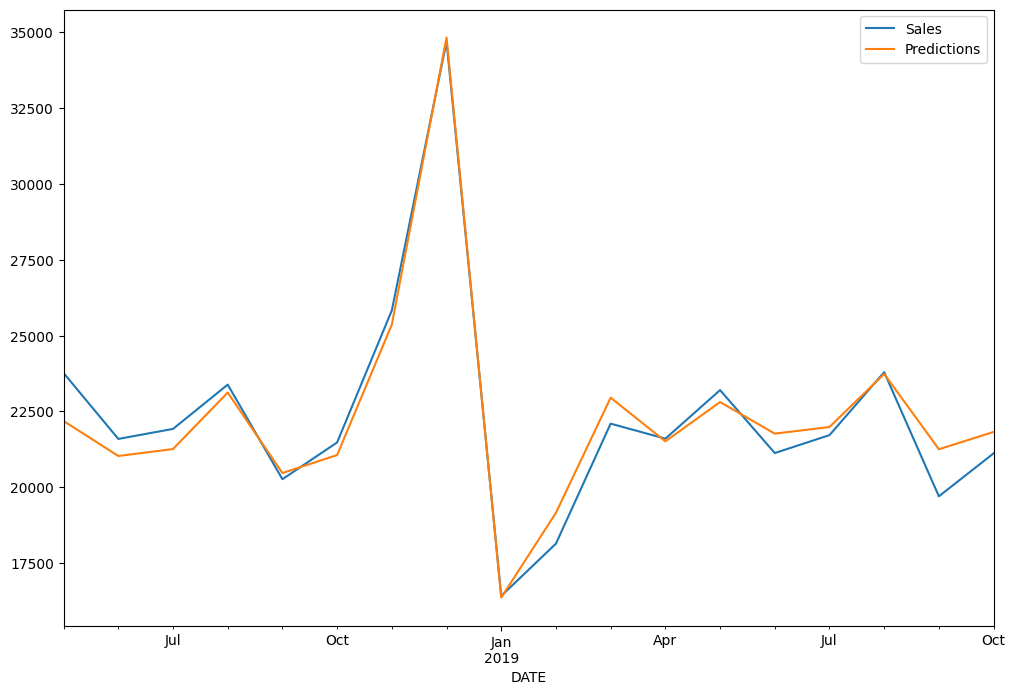

In [113]:
test.plot(figsize=(12,8))

Previsão

In [115]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [116]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [117]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(generator, epochs=8)

Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


322/322 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0427
Epoch 2/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0187
Epoch 3/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0155
Epoch 4/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0092
Epoch 5/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0025
Epoch 6/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0026
Epoch 7/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0014
Epoch 8/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0011


In [118]:
forecast = []

periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):

    # obter previsão 1 passo à frente
    current_pred = model.predict(current_batch)[0]

    # armazena a predição
    forecast.append(current_pred)

    # atualizar lote para incluir agora a previsão e remover o primeiro valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [119]:
forecast = scaler.inverse_transform(forecast)

In [120]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [121]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [122]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [123]:
forecast_df

,Forecast
2019-11-01,25820.722826
2019-12-01,35004.953301
2020-01-01,17583.405513
2020-02-01,18868.201565
2020-03-01,21950.803710
2020-04-01,21695.014083
2020-05-01,23137.895917
2020-06-01,21532.699152
2020-07-01,22082.532832
2020-08-01,23818.081290


<Axes: >

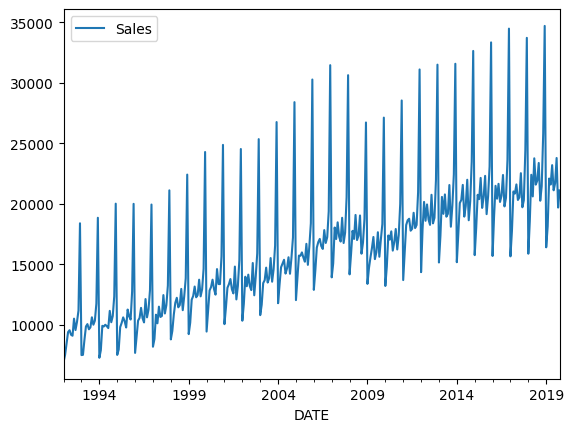

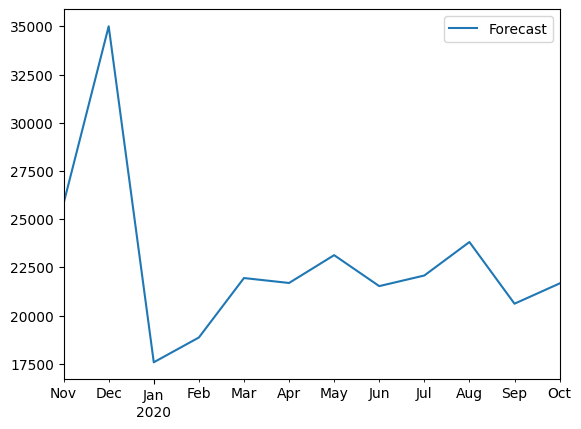

In [124]:
df.plot()
forecast_df.plot()

<Axes: xlabel='DATE'>

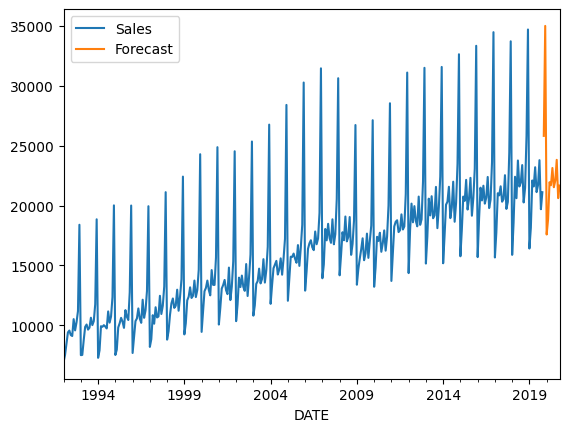

In [125]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

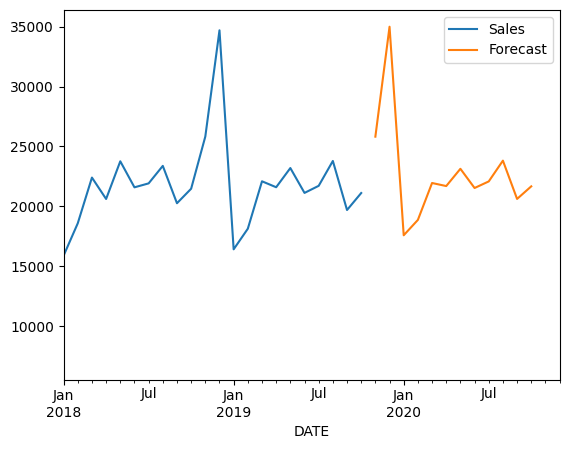

In [126]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')